## Predicting the ad positioning using Q-Learning





Placement of ads on website is the primary problem for companies that operate on ad revenue. The position where the ad is placed plays pivotal role on whether or not the ad will be clicked. Here we have the following choices:

Place them randomly, or
Place the ad on the same position
The problem with placing the ad on the same position is the user, after a certain time, will start ignoring the space since he's used to seeing ad at the place, he will end up ignoring that particular position hereafter. Hence, this will reduce the number of clicks on ads. The problem with the former option, placing them randomly, is it wouldn't take optimal positions into consideration. For instance, text beside images are viewed higher number of times than those text which are placed at a distance. It is infeasible to go through every website and repeat the procedure.

Solution: Reinforcement Learning

Using Reinforcement Learning we can approximate the human behavior.

Why Reinforcement Learning?
We cannot use traditional Machine Learning here, since it requires:

Huge data
Features
Tuning of many hyperparameters
And we neither have huge data, nor features. The only data we have is the position of the banner/ad and whether or not it was clicked. We will use this dataset from Kaggle: https://www.kaggle.com/akram24/ads-ctr-optimisation. We will solve this problem using both model-based (Policy iteration) and model-free methods(Q-Learning & Monte-Carlo). We'll simplify some assumptions for model-based technique.

Notebook Layout
MDP environment - Understanding the dataset
Random Policy - placing the ads randomly on different webpages
Max policy - placing the ad where it is clicked maximum number of times
Model-based Method - Policy Iteration
Model-free Method - Q-learning & Monte Carlo

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time

Dataset
Our environment will be the dataset. It contains 10 ads position per row having values either 1, when the ad is clicked, or 0 when it is not. Every row can be considered as a state in the space, considering it kind of a navigation across multiple pages (on website, for instance) Lets load the dataset and visualize the first few rows.

state = webpage
action = placing the ad at any of the 10 positions on a webpage
reward = +1 if the ad was clicked at the position; else 0
Transition Probability: next webpage that user will end up in is random; therefore, it is 1/(total_webpages -1)

In [2]:
env_data= pd.read_csv("Ads_CTR_Optimisation.csv")
env_data.head()

,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0


In [3]:
env_data.describe()

,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,0.170300,0.129500,0.072800,0.119600,0.269500,0.012600,0.111200,0.209100,0.095200,0.04890
std,0.375915,0.335769,0.259821,0.324509,0.443722,0.111546,0.314395,0.406686,0.293506,0.21567
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [4]:
env_data["Ad 1"].value_counts()

0    8297
1    1703
Name: Ad 1, dtype: int64

### Random policy -
If we were to not have Reinforcement Learning, we would place the ads randomly at given positions. We will now simulate the same



In [5]:
#Choosing a random position to place the ad
reward= 0 # initializing the reward

for i in range(len(env_data)):
    action= np.random.randint(0,10)
    # check if random action matches with the ad position
    if env_data.values[i][action] == 1:
      # Increase the rewards if the position matches
      reward += 1
print("Total reward: {}".format(reward))

Total reward: 1244


The total rewards is too low as compared to the data


### Using Max Policy
Another question we might ask: is it right to display the ad where it is clicked the most number of times. For instance, there might be a certain position where the ad clicked with a higher probability. Since the values of the rows is either 1 or 0, we can sum across the columns and count the number of times ad in the position was clicked.

In [6]:
click_counts= env_data.sum(axis=0)
counts= pd.DataFrame({"ad": np.arange(1,11), "counts": click_counts})
counts.set_index("ad")

,counts
ad,
1,1703
2,1295
3,728
4,1196
5,2695
6,126
7,1112
8,2091
9,952


Which indicates ad 5 was clicked 2695 times. So if we were to always place an ad on position 5, it would be click around 2695 times. But can we do better?

## Dynamic Programming - Policy iteration

In [7]:
state_size = len(env_data)

state_list = []
for state in range(state_size):
    state_list.append(state)

In [8]:
start= time.time()

# Action can be placing the at any of the ten positions.
action_space= np.arange(0,10)
policy= [random.choice(action_space) for x in range(state_size)]
# Taking random action for the first time
first_time= True
#Delta
small_change= 1e-20
#Discount Factor
gamma= 0.9

episodes= 0
max_episodes= 500

V= dict()
# Setting terminal state reward to 1
V[10000]= 1
# initializing Value function for all states with random values between 0 to 1
for i in range(state_size):
  V[i]= np.random.random()
deltas=[]

while episodes < max_episodes:
  # Untill the convergence of state_value function doing Policy evaluation
  while True:
    if episodes > max_episodes:
      break
    episodes += 1
    if episodes % 100 == 0:
      print("Current episode is {}".format(episodes) )
    biggest_change= 0
    # looping through all states
    for state in range(state_size):
      old_V= V[state]
      #Taking random action according to policy
      action= policy[state]
      new_state= random.choice(list(set(state_list)-set([state])))
      rewards=env_data.values[state][action]
      V[state]= (rewards + gamma*(V[new_state]))/9999
      # Here We are calculating biggest change to have an idea on convergence.
      # Initially, the changes will be huge, but as we update the values, they will tend towards a convergence point
      biggest_change= max(biggest_change, abs(V[state] - old_V))
    deltas.append(biggest_change)
    if biggest_change < small_change:
        break
  #Policy Improvement
  policy_changed= False
  for state in range(state_size):
    best_val= -np.inf
    best_action= -1
    for action in action_space:
      new_state= random.choice(list(set(state_list)-set([state])))
      rewards=env_data.values[state][action]
      future_reward= (rewards + gamma * V[new_state])/9999
      if future_reward > best_val:
        best_val= future_reward
        best_action= action
    assert best_action != -1
    if policy[state] != best_action:
      policy_changed= True
    policy[state]=best_action

  if not policy_changed:
    break

end=time.time()
print("Total time taken {}".format(end-start))
print("Total no. of episodes {}".format(episodes))

Current episode is 100
Current episode is 200
Current episode is 300
Current episode is 400
Current episode is 500
Total time taken 2313.677437067032
Total no. of episodes 501


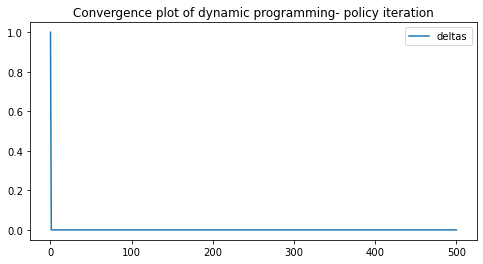

In [9]:
plt.rcParams["figure.figsize"]=(8,4)
plt.plot(deltas, label= "deltas")
plt.legend()
plt.title("Convergence plot of dynamic programming- policy iteration")
plt.tight_layout
plt.show()

In [10]:
rewards= 0

for j in range(state_size):
  action= policy[j]
  if env_data.values[j][action] == 1:
    rewards += 1
print("Total Rewards from policy iteration: {}".format(rewards))

Total Rewards from policy iteration: 7424


### Using Q-Learning
The reason for using Q-Learning here is :

It is model free, so it doesn't require to know all the states.
Intuitive to understand, and converges faster.
We will use Q-Learning with Epsilon Decay. Initially, we will start with a very high epsilon value. Which would make the model explore, instead of exploit. After a few iterations, we will reduce this "exploration probability" so the model will exploit, instead of exploring. After many iterations, the model would have high confidence and no more exploration is necessary.

This strategy is called as "epsilon greedy". We will use a decay rate to change the epsilon value such that it becomes lower after many iterations.

In [11]:
# Initializing parameters required for q-learning
states= len(env_data)
actions=10

# initializing q-values to zero
q_table= np.zeros((states+1, actions))


learning_rate=0.7
gamma=0.618

# setting exploration probability to high value initially
epsilon=1
min_epsilon= 0.01
max_epsilon= 1
decay_rate=0.01
max_episodes=500

In [12]:
def exploit(eps):
  # decides whether or not to exploit
  return np.random.uniform() > eps

def random_action():
  return np.random.randint(0,10)

In [13]:
deltas= []
reward=0

for episode in range(max_episodes+1):
  if episode % 25 == 0:
    print("Current episode: {}".format(episode))
  biggest_change=0
  for state in range(states):
    if exploit(epsilon):
      action= random_action()
    else:
      action= np.argmax(q_table[state])
    r= env_data.values[state][action]
    reward += r
    old_q= q_table[state][action]
    new_state= random.choice(list(set(state_list)-set([state])))
    q_table[state][action] += learning_rate*(r+gamma*np.max(q_table[new_state,:])-q_table[state][action])
    biggest_change= max(biggest_change, abs(q_table[state][action]-old_q))
  deltas.append(biggest_change)
  epsilon= min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*episode)

Current episode: 0
Current episode: 25
Current episode: 50
Current episode: 75
Current episode: 100
Current episode: 125
Current episode: 150
Current episode: 175
Current episode: 200
Current episode: 225
Current episode: 300
Current episode: 325
Current episode: 350
Current episode: 375
Current episode: 400
Current episode: 425
Current episode: 450
Current episode: 475
Current episode: 500


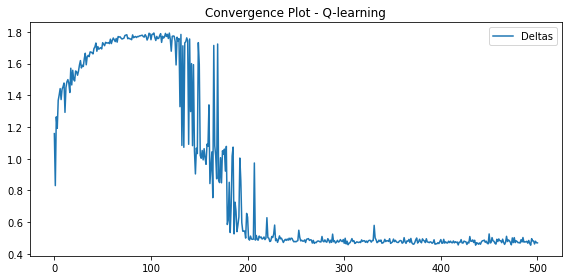

In [14]:
plt.plot(deltas, label="Deltas")
plt.legend()
plt.title("Convergence Plot - Q-learning")
plt.tight_layout()

In [17]:
rewards= 0
for state in range(states):
    best_action= np.argmax(q_table[state,:])
    r=  env_data.values[state][best_action]
    rewards += r
print("Total Rewards: {}".format(rewards))

Total Rewards: 7424


## Monte Carlo Method

In [7]:
def random_policy(state):
  return np.random.randint(0,10)

def simulate(policy):
  rsa= []

  for s in range(env_data.shape[0]):
    if np.random.uniform() < 0.1:
      action= np.random.randint(0,10)
    else:
      action= policy[s]
    rewards=env_data.values[s][action]
    rsa.append((rewards, s, action))

  G= 0
  gamma= 0.3
  first= True
  state_returns= []
  for rewards, s, a in reversed(rsa):
    G= G + gamma * rewards
    if first:
      first= False
      continue
    else:
      state_returns.append((s, a, G))
      state_returns.reverse()
  return state_returns

In [8]:
from collections import defaultdict

policy= {s: np.random.randint(0,10) for s in range(10000)}
Q= np.zeros(env_data.values.shape)
returns= defaultdict(list)
deltas= []
episodes= 2000
for x in range(episodes):
  if x % 100 == 0:
    print("Current episode {}".format(x))
  state_returns= simulate(policy)
  change= 0.0
  for state, action, G in state_returns:
    old_q= Q[state][action]
    returns[(state, action)].append(G)
    Q[state][action]= np.mean(returns[(state, action)])
    change= np.maximum(change,np.abs(Q[state][action]-old_q).astype(np.int))
  deltas.append(change)
  for s in range(10000):
    policy[s]= np.argmax(Q[s,:])

Current episode 0


/tmp/ipykernel_406/1751381815.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  change= np.maximum(change,np.abs(Q[state][action]-old_q).astype(np.int))


Current episode 100
Current episode 200
Current episode 300
Current episode 400
Current episode 500
Current episode 600
Current episode 700
Current episode 800
Current episode 900
Current episode 1000
Current episode 1100
Current episode 1200
Current episode 1300
Current episode 1400
Current episode 1500
Current episode 1600
Current episode 1700
Current episode 1800
Current episode 1900


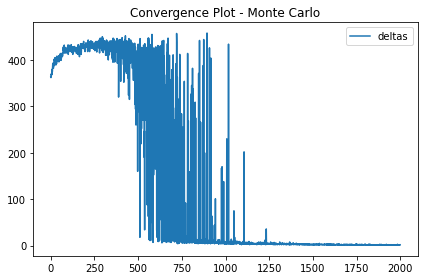

In [13]:
plt.plot(deltas, label="deltas")
plt.legend()
plt.title("Convergence Plot - Monte Carlo")
plt.tight_layout()

In [14]:
# calculationg rewards
rewards= 0
for i in range(le):
    a= np.argmax(Q[s,:])
    rewards += env_data.values[s][a]
print(rewards)

0
